# PTIR Data from Harvested Biomass Samples
## Setup
### Library Imports
#### Maths and Plotting

In [1]:
import numpy as np

import scipy as sp

import sklearn.decomposition as decomp

import matplotlib as mpl
import matplotlib.pyplot as plt

#### I/O

In [2]:
import glob

import yaml
import h5py

import pprint

#### PTIR dataset handling

In [3]:
import ptirtools as ptir

### Load Config

In [4]:
CONFIG = None
with open("config.yml", 'r') as handle:
    CONFIG = yaml.safe_load(handle)
assert CONFIG is not None , "Failed to load config file."
pprint.pp(CONFIG)

{'directories': {'ptirfiles': './ptirfiles', 'output': './output'}}


In [5]:
COLORS = None
with open("gruvbox_colors.yml", 'r') as handle:
    COLORS = yaml.safe_load(handle)
assert COLORS is not None , "Failed to load config file."

## Load Data
### Search for Input Files

In [6]:
INPUT_FILE_NAMES = glob.glob(f"{CONFIG['directories']['ptirfiles']}/*.ptir")
INPUT_FILE_NAMES = [ f.split("/")[-1] for f in INPUT_FILE_NAMES ]
INPUT_FILE_NAMES

['[6] 0,19 g.ptir',
 '[1] 0,1476.ptir',
 '[5] 98,6mg.ptir',
 '[2] 0.01.25.ptir',
 '[8] 0,20 g (before crash).ptir',
 '[7] A. platensis.ptir',
 '[4] 0,1653g.ptir',
 '[3] 30.01.25.ptir']

### Load Relevant Data
#### Accumulate from Files

In [7]:
DATA = {}

for ifn in INPUT_FILE_NAMES:
    h5file = h5py.File(f"{CONFIG['directories']['ptirfiles']}/{ifn}", 'r')
    DATA[ifn] = ptir.h5Group2Dict( h5file, h5file, [] )
    h5file.close()

#### Extract Image and Spectral Data

In [8]:
SAMPLES = { fn:dict(index=int(fn[1]), images=[], spectra=[]) for i,fn in enumerate(INPUT_FILE_NAMES) }

In [9]:
for filename,data in DATA.items():
    for img_key, image in data["Images"].items():
        image_data = image['data']
        metadata = image['meta']

        SAMPLES[filename]["images"].append( dict(data=image_data, extent=ptir.image_extent(metadata)) )

In [10]:
for filename,data in DATA.items():
    for meas_key, measurement in data.items():
        if meas_key.startswith("Measurement_"):
            if not bool(measurement['attribs']['IsBackground']):
                wavenumbers = measurement['Spectroscopic_Values']['data']
                channels = [ y['Raw_Data']['data'] for ch,y in measurement.items() if ch.startswith("Channel_") ]
                if len(channels) > 0:
                    SAMPLES[filename]['spectra'].append(
                        dict( 
                            position=tuple( measurement['attribs'][f"Location{X}"][0] for X in "XYZ" ),
                            wavenumbers=np.array(wavenumbers[0]), 
                            channels=np.array([channel[0] for channel in channels]),
                        )
                    )


## Inspection

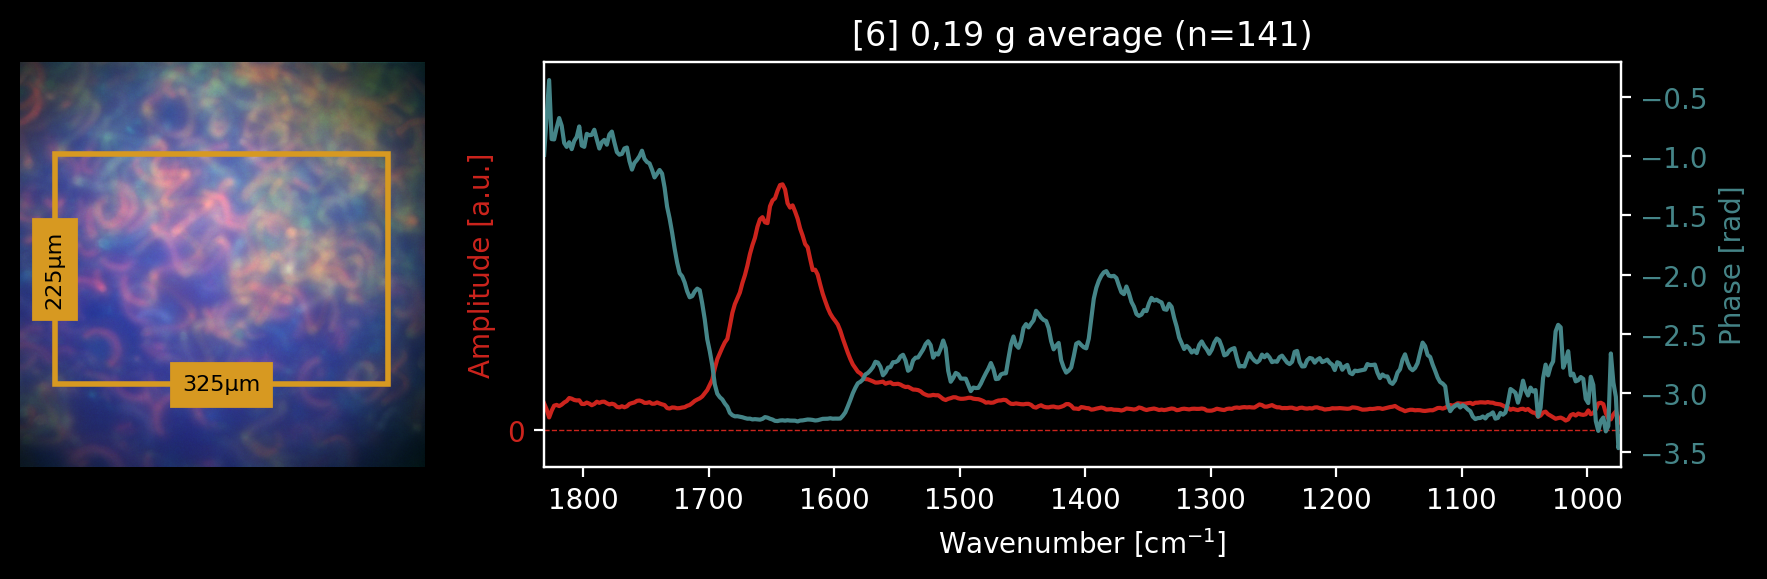

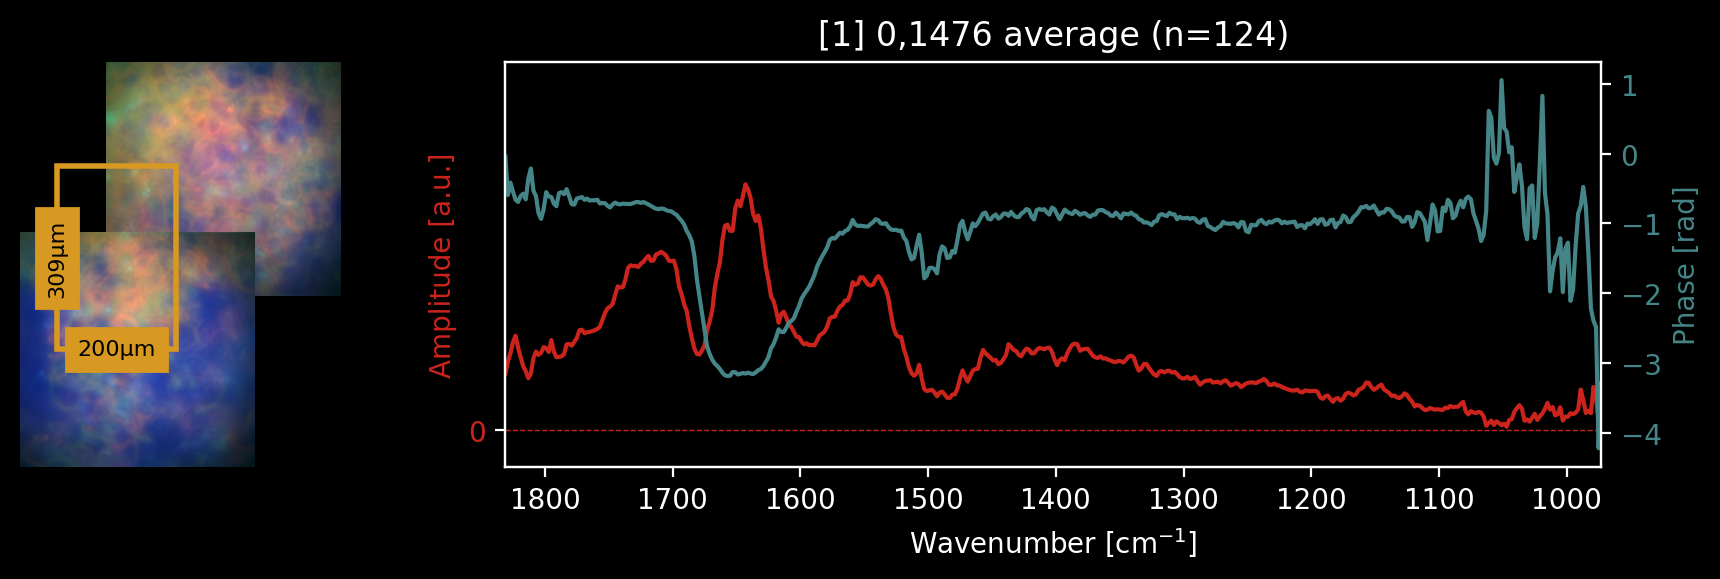

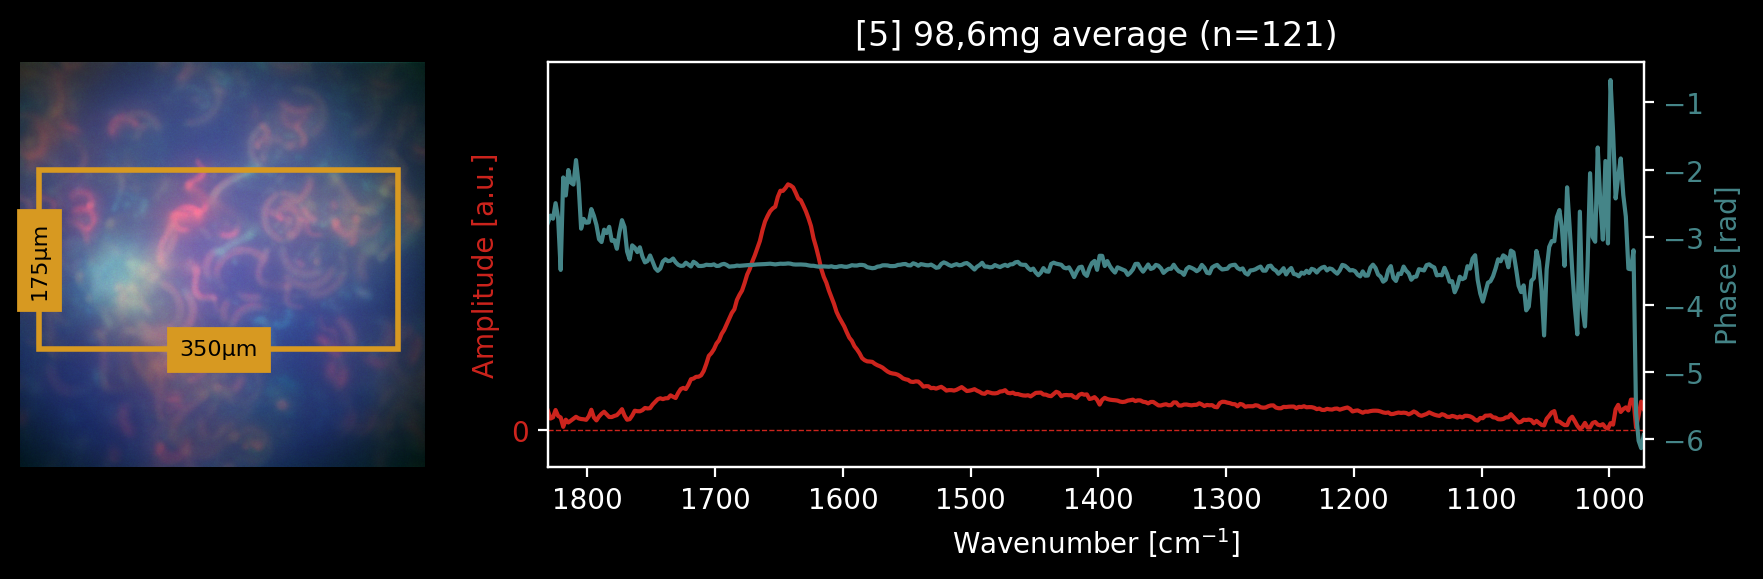

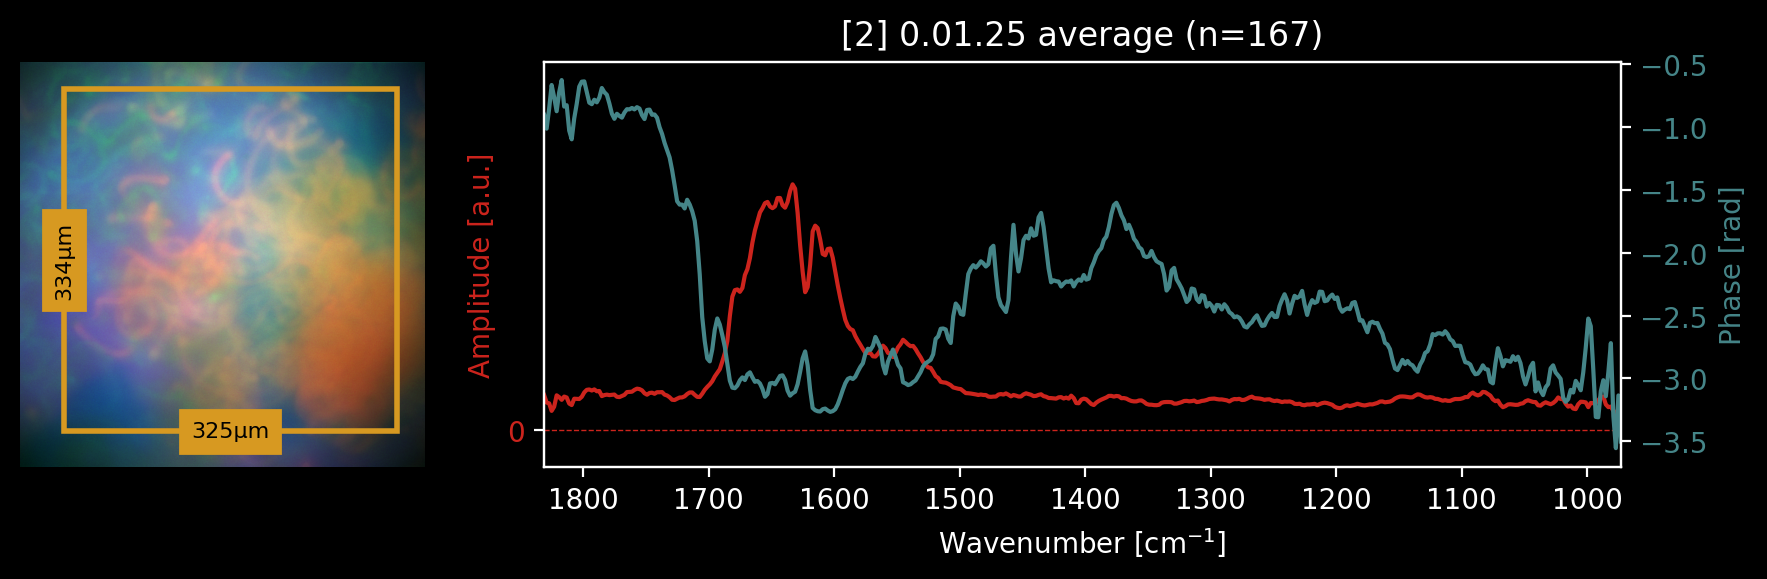

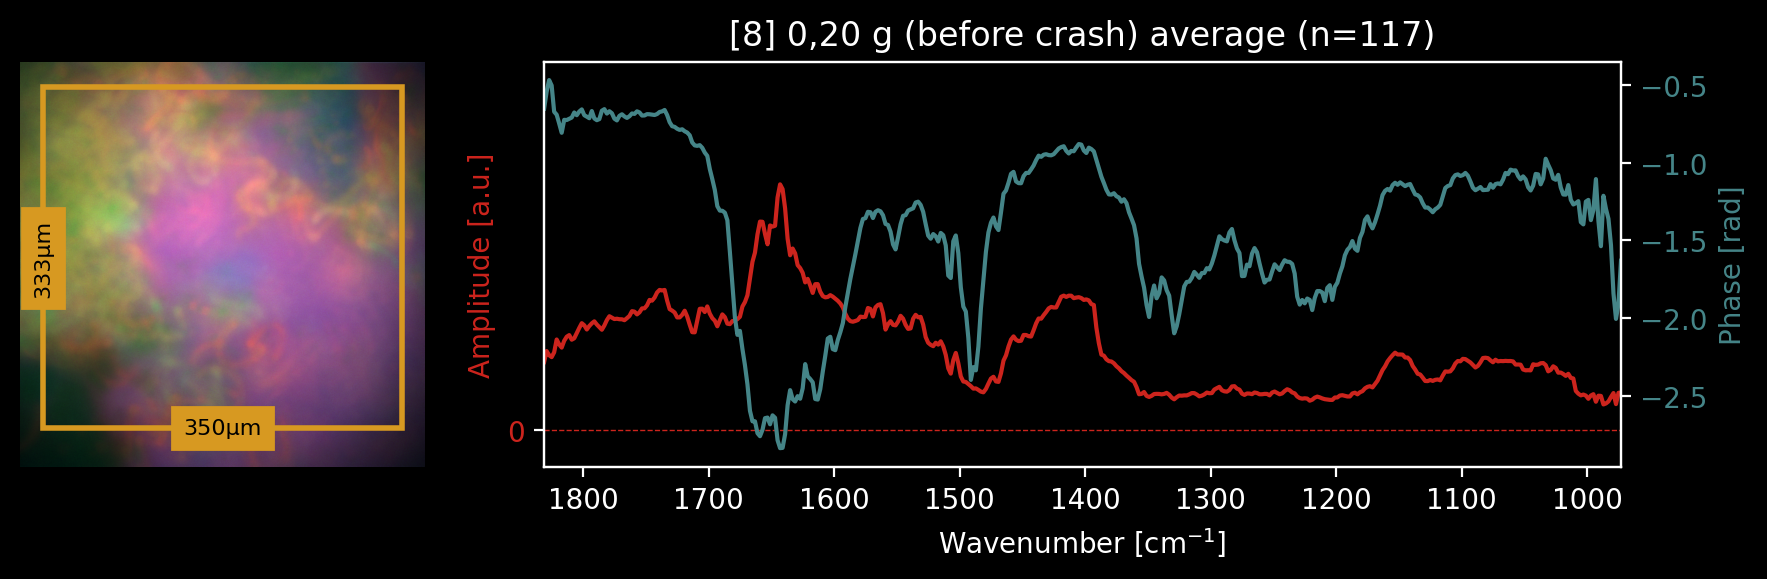

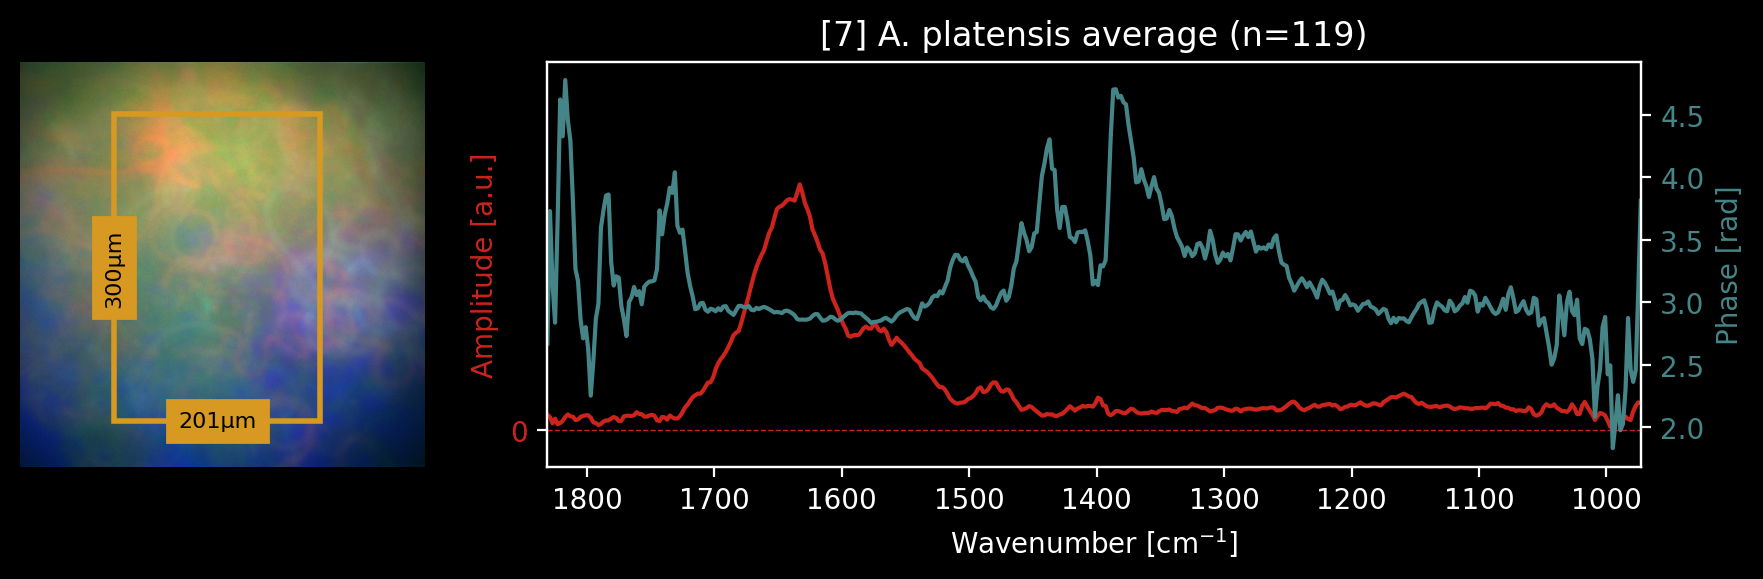

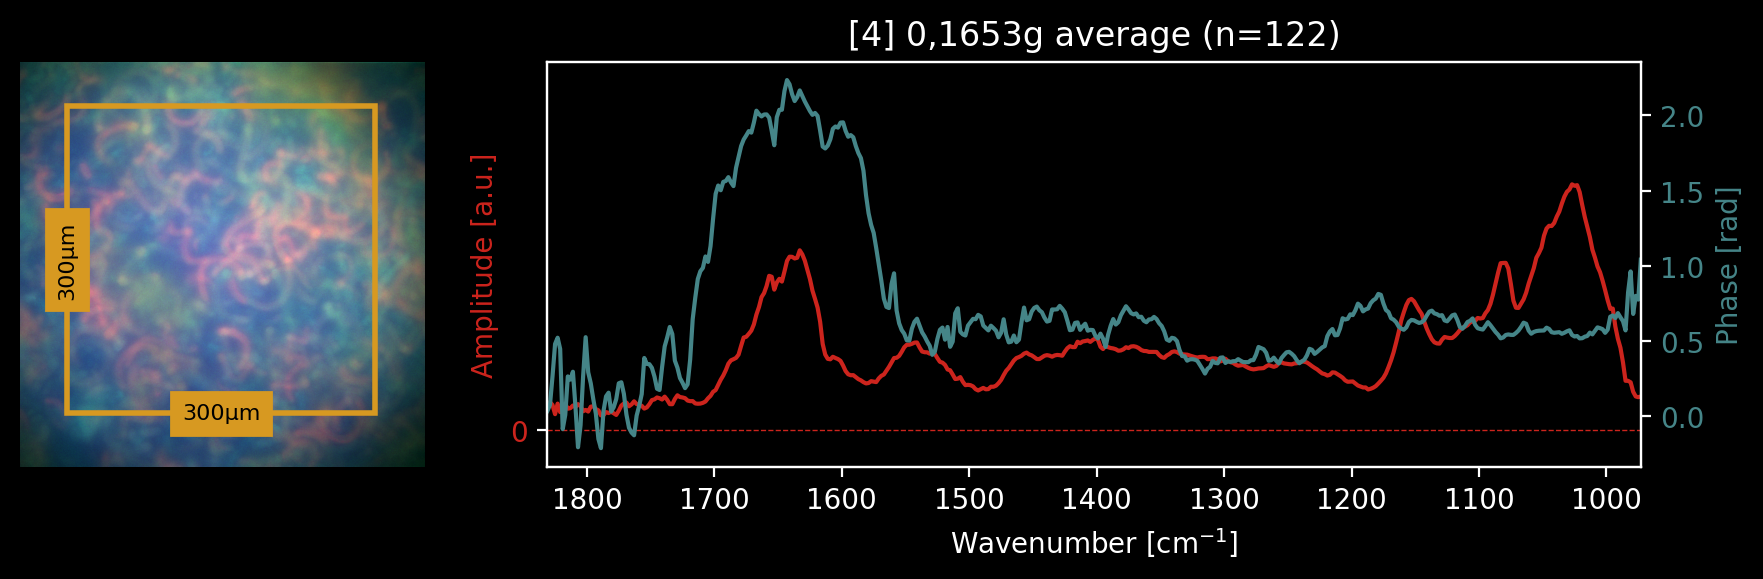

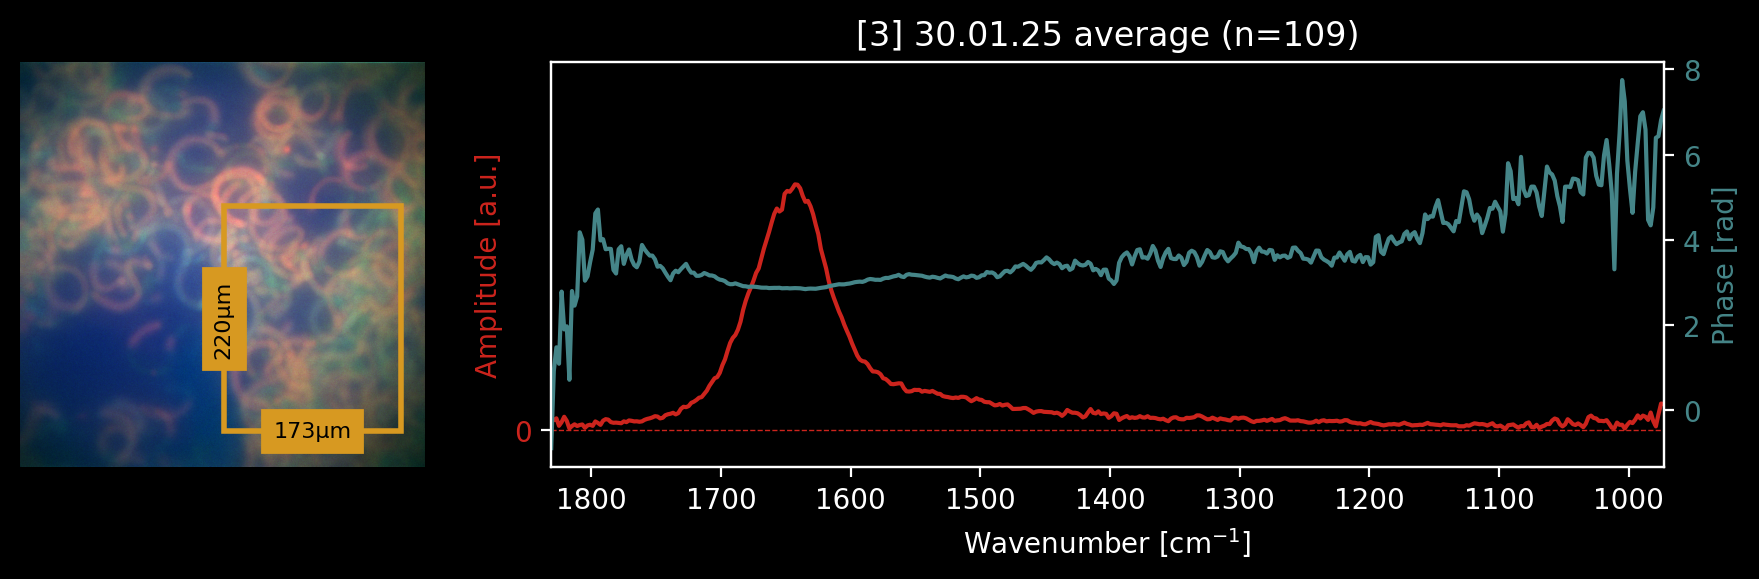

In [11]:
for fn,data in SAMPLES.items():
    fig = plt.figure( figsize=(9,3) , dpi=200 )
    gs = fig.add_gridspec( 1, 2, width_ratios=[1,2.5] )
    
    ax = fig.add_subplot( gs[1] )

    positions = np.zeros( (2, len(data['spectra'])) )
    accumulator = np.zeros( (len(data['spectra']), *data['spectra'][0]['channels'][0].shape), dtype=np.complex128 )
    wavenumbers = data['spectra'][0]['wavenumbers']
    ### TODO: check that the domains are the same
    for ispec,spectrum in enumerate(data['spectra']):
        _optir, _phase, _x, _y = spectrum['channels']
        _amplitude = _x + 1j*_y
        accumulator[ispec] += _amplitude
        #ax.plot( wavenumbers, np.abs(_amplitude), color=COLORS['normal']['yellow'], alpha=0.1 )
        positions[0,ispec] = spectrum['position'][0]
        positions[1,ispec] = spectrum['position'][1]
    ax.plot( wavenumbers, np.abs(np.mean(accumulator, axis=0)), color=COLORS['normal']['red'], label='avg. amplitude' )
    ax.plot( [], [], color=COLORS['normal']['blue'], label='avg. phase' )
    ax2 = ax.twinx()
    ax2.plot( wavenumbers, np.unwrap(np.angle(np.mean(accumulator, axis=0)[::-1]))[::-1], color=COLORS['normal']['blue'] )
    ax.set_xlabel("Wavenumber [cm$^{-1}$]")
    ax.set_ylabel("Amplitude [a.u.]", color=COLORS['normal']['red'])
    ax.set_yticks([0])
    ax2.set_ylabel("Phase [rad]", color=COLORS['normal']['blue'])
    ax.tick_params(axis='y', labelcolor=COLORS['normal']['red'])
    ax2.tick_params(axis='y', labelcolor=COLORS['normal']['blue'])
    ax.set_ylim(ymax=1.5*np.max(np.abs(np.mean(accumulator, axis=0))), ymin=-0.15*np.max(np.abs(np.mean(accumulator, axis=0))))

    ax.set_xlim(xmin=np.min(wavenumbers), xmax=np.max(wavenumbers))
    ax.axhline( 0, c=COLORS['normal']['red'], lw=0.5, ls='--' )
    ax.set_title( f"{fn[:-len('.ptir')]} average (n={len(accumulator)})" )
    ax.invert_xaxis()
    #ax.get_yaxis().set_visible(False)

    xmin,ymin = np.min(positions,axis=1)
    xmax,ymax = np.max(positions,axis=1)

    ax = fig.add_subplot( gs[0] )
    for image in data["images"]:
        ax.imshow( image["data"], extent=image['extent'] )
    
    ax.fill( 
        [xmin, xmax, xmax, xmin],
        [ymin, ymin, ymax, ymax],
        fill=False,
        color=COLORS['normal']['yellow'],
        lw=2
    )
    ax.text(
        0.5*(xmin+xmax), ymin,
        f"{xmax-xmin:.0f}µm",
        size=8, color='k', va='center', ha='center', backgroundcolor=COLORS['normal']['yellow']
    )
    ax.text(
        xmin, 0.5*(ymin+ymax), 
        f"{ymax-ymin:.0f}µm",
        size=8, color='k', va='center', ha='center', backgroundcolor=COLORS['normal']['yellow'], rotation=90
    )
    ax.set_axis_off()

    fig.tight_layout()
    plt.show()
    fig.savefig(f"{CONFIG['directories']['output']}/{fn[:-len('.ptir')]} average.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

## Dimension Reduction
We are dealing with quite a large amount of data. Even if the spectra were perfectly precise (which they definitely aren't), to make any statements about the samples, we must somehow reduce the number of variables we're analyzing. 

A basic way to do that is **PCA**. To implement that, we would write all the spectra (in $X+\mathfrak{i}Y$ form) into a huge matrix. As additional components, we would include any kind of classification we can tag the spectra with. That is, for instance, the sample it appears in (but not the index of the sample as a value, but a bitmap whose size is the number of samples and all bits are zero except the one at the position that corresponds to the sample) and the values of the RGB fluorescence channels.

Another way would be to **fit a fixed number of Gaussians** to each individual spectrum and then try to correlate these to the classifications. Each Gaussian would have as parameters just magnitude and width. The central value would have to be pre-set to ensure comparability, though a small deviation parameter may be included, allowing the bell curve to shift a few wavenumbers. Central value, offset and width shall be real-valued, the amplitude may be complex-valued.

Likely locations where we would expect to find peaks and should thus start the gaussians for fitting at are...
`LIKELY_PEAK_LOCATIONS = [ 1649 , 1551 , 1731 , 1479 , 1151 , 1079 , 1031 ]`

### Arrange all spectra into one data structure

We'll allocate an array with dimensions
- number of spectra
- (number of samples) + 3 (number of wide field image channels) + (number of manually determined classes) + (number of wavenumbers)

and then start slicing...

In [12]:
NUM = {
    'samples' : 0,
    'widefieldchannels' : 3,
    'classes' : 0,
    'spectra' : 0,
}
for fn,data in SAMPLES.items():
    NUM['samples'] = max( NUM['samples'] , int(fn[1])+1 )
    NUM['spectra'] += len(data['spectra'])
WAVENUMBERS = np.copy(data['spectra'][0]['wavenumbers'])
NUM['wavenumbers'] = len(WAVENUMBERS)

OFFSET = { key:sum( [ NUM[key2] for key2 in list(NUM.keys())[:list(NUM.keys()).index(key)] ] ) for key in NUM }
del OFFSET['wavenumbers']

In [13]:
pprint.pp( dict( NUM=NUM ) )
pprint.pp( dict( OFFSET=OFFSET ) )


{'NUM': {'samples': 9,
         'widefieldchannels': 3,
         'classes': 0,
         'spectra': 1020,
         'wavenumbers': 430}}
{'OFFSET': {'samples': 0, 'widefieldchannels': 9, 'classes': 12, 'spectra': 12}}


In [14]:
DATASET = np.zeros( ( NUM['spectra'] , sum([NUM[key] for key in NUM.keys() if key != 'spectra']) ) , dtype=np.complex128 )
print(DATASET.shape)
SORTED_FILES = {}

(1020, 442)


In [15]:
idx_dataset = 0

for fn,data in SAMPLES.items():
    idx_file = int(fn[1])
    SORTED_FILES[idx_file] = fn[:-len('.ptir')]

    for ispec,spectrum in enumerate(data['spectra']):
        DATASET[idx_dataset,idx_file] = 1.0
        _optir, _phase, _x, _y = spectrum['channels']
        #DATASET[idx_dataset,OFFSET['spectra']:] += _x + 1j*_y
        ### analyse only amplitude, not complex phase
        DATASET[idx_dataset,OFFSET['spectra']:] += _x**2 + _y**2

        idx_dataset += 1


Classes and wide field colours remain to be done...

### Unguided Singular Value Decomposition
Since `sklearn.decomposition.PCA` does not support complex-valued input...

In [16]:
UMAT, SIGMA, VADJ = sp.linalg.svd( DATASET, full_matrices=False )

In [17]:
MANUAL_PCA = { 'explained_variance' : (SIGMA**2) / DATASET.shape[0] }
MANUAL_PCA['explained_variance_ratio'] = MANUAL_PCA['explained_variance']/np.sum(MANUAL_PCA['explained_variance'])

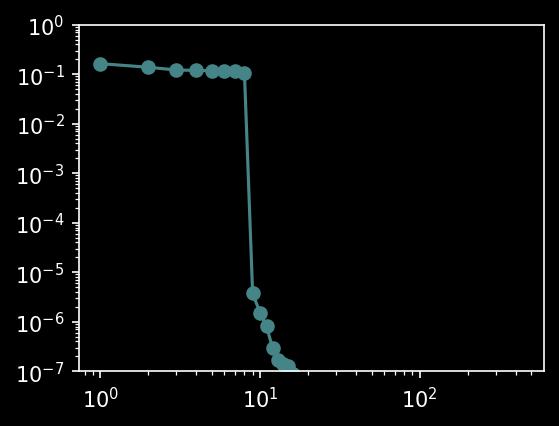

In [18]:
fig = plt.figure( figsize=(4,3), dpi=150 )
ax = fig.add_subplot()
ax.plot(
    np.arange(len(MANUAL_PCA['explained_variance_ratio']))+1,
    MANUAL_PCA['explained_variance_ratio'], 
    color=COLORS['normal']['blue'], marker='o'
)
ax.set_yscale("log")
ax.set_ylim(ymin=1e-7, ymax=1)
ax.set_xscale("log")
plt.show()

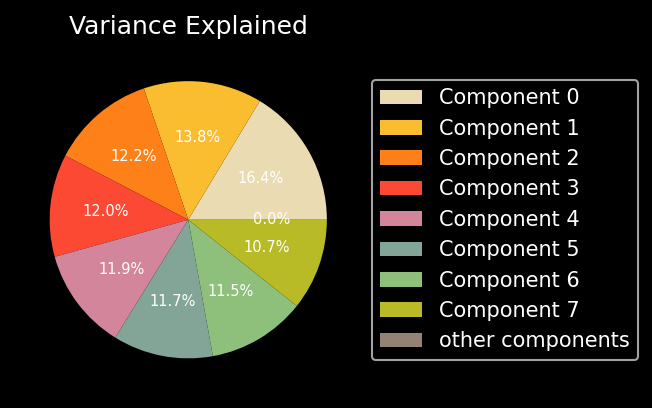

In [19]:
fig = plt.figure( figsize=(6,3), dpi=150 )
ax = fig.add_subplot()

cutoff = 8
pie = dict()
pie['x'] = [ r for r in MANUAL_PCA['explained_variance_ratio'][:cutoff] ]
pie['x'].append( np.sum( [ r for r in MANUAL_PCA['explained_variance_ratio'][cutoff:] ] ) )
pie['colors'] = [ COLORS['bright'][c] for c in ["yellow","orange","red","purple","blue","aqua","green"] ]
pie['colors'].insert(0,COLORS['light_to_dark'][4])
pie['colors'].append(COLORS['normal']['gray'])
pie['autopct'] = lambda pct: f"{pct:.1f}%"
pie['textprops'] = dict( size=7 )

wedges,texts,autotexts = ax.pie(**pie)

ax.legend(
    wedges, 
    [f"Component {i}" for i in range(cutoff)]+["other components"],
    loc="center left",
    bbox_to_anchor=(1,0,0.5,1)
)

ax.set_title(f"Variance Explained")

plt.show()
del pie, cutoff, wedges, texts, autotexts

In [20]:
fig.savefig(f"{CONFIG['directories']['output']}/../SVD_variance_explained.png", dpi=300, bbox_inches='tight')

Apparently, the first 8 components are significant, from then on, we have mostly noise over-fitting. So let's have a look at these 8 components:

In [21]:
CUTOFF = 8
SVDCOLORS = [ COLORS['normal'][c] for c in ["yellow","orange","red","purple","blue","aqua","green"] ]
SVDCOLORS.insert(0,COLORS['light_to_dark'][4])
SVDCOLORS.append(COLORS['normal']['gray'])

In [22]:
FEATURE_NAMES = ["None"] + [ SORTED_FILES[i] for i in sorted(list(SORTED_FILES.keys())) ]+[ "R", "G", "B" ]

In [23]:
FEATURE_NAMES

['None',
 '[1] 0,1476',
 '[2] 0.01.25',
 '[3] 30.01.25',
 '[4] 0,1653g',
 '[5] 98,6mg',
 '[6] 0,19 g',
 '[7] A. platensis',
 '[8] 0,20 g (before crash)',
 'R',
 'G',
 'B']

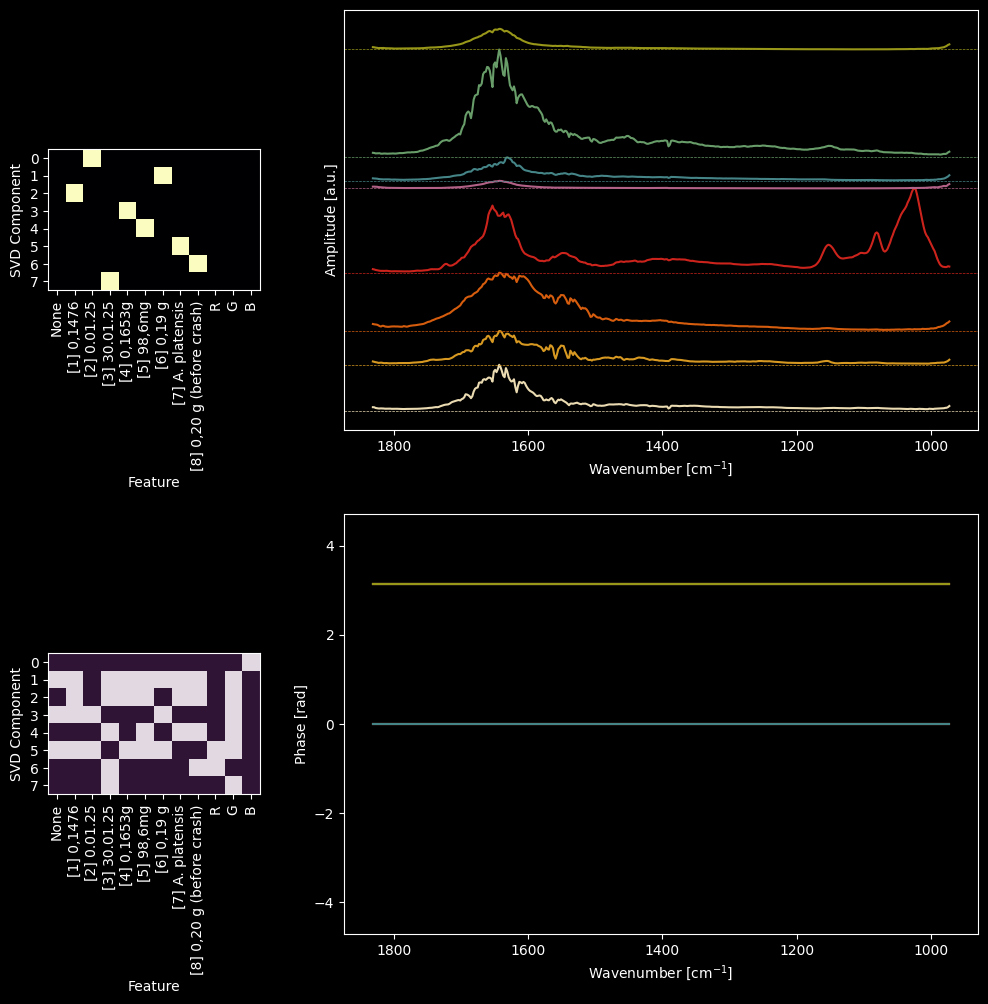

In [24]:
fig = plt.figure( figsize=(12,12), dpi=100 )
gs = fig.add_gridspec( 2, 2, width_ratios=[1,3] )

axes = [ 
    fig.add_subplot( gs[0,1] ), 
    fig.add_subplot( gs[1,1] ), 
    fig.add_subplot( gs[0,0] ), 
    fig.add_subplot( gs[1,0] ), 
]

y_offset_abs = 0

for idx in range(CUTOFF):
    component = VADJ[idx,OFFSET['spectra']:]
    axes[0].plot( WAVENUMBERS, np.abs(component) + y_offset_abs, color=SVDCOLORS[idx] )
    axes[0].axhline( y_offset_abs, ls='--', lw=0.5, color=SVDCOLORS[idx] )
    y_offset_abs += np.max(np.abs(component))
    _phase = np.unwrap(np.angle(component))
    midphase = (np.max(_phase) + np.min(_phase))/2
    axes[1].plot( WAVENUMBERS, _phase - 2*np.pi*np.round(midphase/2/np.pi), color=SVDCOLORS[idx] )

axes[1].set_ylim(ymin=-1.5*np.pi, ymax=1.5*np.pi)
axes[1].set_ylabel("Phase [rad]")
axes[0].set_ylabel("Amplitude [a.u.]")
axes[0].set_yticks([])

for ax in axes[:2]:
    ax.invert_xaxis()
    ax.set_xlabel("Wavenumber [cm$^{-1}$]")

axes[2].imshow( np.abs(  VADJ[:CUTOFF,:OFFSET['spectra']]), cmap='magma' )
axes[3].imshow( np.angle(VADJ[:CUTOFF,:OFFSET['spectra']]), cmap='twilight', vmin=-np.pi, vmax=np.pi )

for ax in axes[2:]:
    ax.set_ylabel("SVD Component")
    ax.set_xlabel("Feature")
    ax.set_xticks(
        ticks = list(range(len(FEATURE_NAMES))),
        labels = FEATURE_NAMES,
        rotation=90
    )
    ax.set_yticks( ticks = list(range(CUTOFF)) )

plt.show()

In [25]:
fig.savefig(f"{CONFIG['directories']['output']}/../SVD_components.png", dpi=300, bbox_inches='tight')

It appears, that the 8 principal components we see are just the average spectra of the 8 samples. 